In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
alpha = 9.7e-5
file_path = '/content/square.xlsx'
df = pd.read_excel(file_path)
df = df[['x-coordinate', 'y-coordinate', 'time', 'temperature']].dropna()

In [ ]:
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df[['x-coordinate', 'y-coordinate', 'time']].values)
y = df['temperature'].values.reshape(-1, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(3,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

In [ ]:
model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
@tf.function
def compute_loss(xy, true_temp):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xy)
        pred_temp = model(xy)
        grad = tape.gradient(pred_temp, xy)
        dT_dx = grad[:, 0:1]
        dT_dy = grad[:, 1:2]
        d2T_dx2 = tape.gradient(dT_dx, xy)[:, 0:1]
        d2T_dy2 = tape.gradient(dT_dy, xy)[:, 1:2]
        physics_residual = alpha * (d2T_dx2 + d2T_dy2)
    mse_data = tf.reduce_mean((pred_temp - true_temp) ** 2)
    mse_phys = tf.reduce_mean(physics_residual ** 2)
    total_loss = mse_data + mse_phys
    return total_loss, mse_data, mse_phys

In [ ]:
def train(model, X_train, y_train, epochs=3000):
    train_losses = []
    data_losses = []
    phys_losses = []
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss, data_loss, phys_loss = compute_loss(tf.convert_to_tensor(X_train, dtype=tf.float32),
                                                      tf.convert_to_tensor(y_train, dtype=tf.float32))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_losses.append(loss.numpy())
        data_losses.append(data_loss.numpy())
        phys_losses.append(phys_loss.numpy())
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Total Loss={loss:.2f}, Data Loss={data_loss:.2f}, Physics Loss={phys_loss:.2f}")
    return train_losses, data_losses, phys_losses

In [ ]:
train_loss, data_loss, phys_loss = train(model, X_train, y_train, epochs=3000)

Epoch 0: Total Loss=73426.58, Data Loss=73426.58, Physics Loss=0.00
Epoch 100: Total Loss=57140.71, Data Loss=57140.71, Physics Loss=0.00
Epoch 200: Total Loss=18051.37, Data Loss=18051.37, Physics Loss=0.00
Epoch 300: Total Loss=14147.55, Data Loss=14147.55, Physics Loss=0.00
Epoch 400: Total Loss=10129.22, Data Loss=10129.22, Physics Loss=0.00
Epoch 500: Total Loss=5153.60, Data Loss=5153.60, Physics Loss=0.00
Epoch 600: Total Loss=1760.46, Data Loss=1760.46, Physics Loss=0.00
Epoch 700: Total Loss=1109.69, Data Loss=1109.69, Physics Loss=0.00
Epoch 800: Total Loss=839.56, Data Loss=839.56, Physics Loss=0.00
Epoch 900: Total Loss=646.43, Data Loss=646.43, Physics Loss=0.00
Epoch 1000: Total Loss=557.14, Data Loss=557.14, Physics Loss=0.00
Epoch 1100: Total Loss=506.84, Data Loss=506.84, Physics Loss=0.00
Epoch 1200: Total Loss=460.79, Data Loss=460.79, Physics Loss=0.00
Epoch 1300: Total Loss=394.49, Data Loss=394.49, Physics Loss=0.00
Epoch 1400: Total Loss=322.40, Data Loss=322.40,

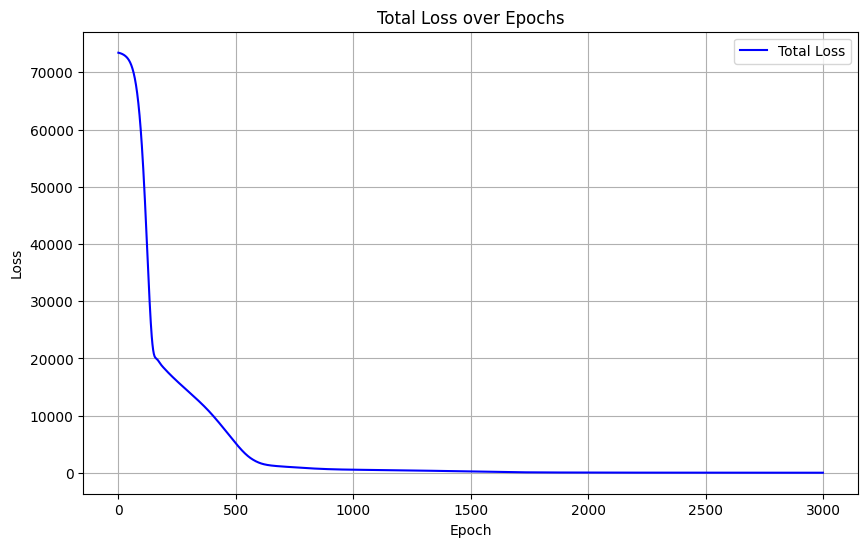

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Total Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_pred = model(X_test_tensor).numpy()

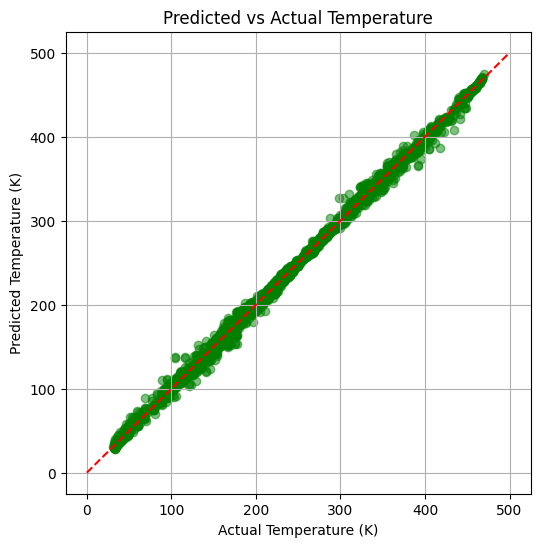

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([0, 500], [0, 500], 'r--')
plt.xlabel("Actual Temperature (K)")
plt.ylabel("Predicted Temperature (K)")
plt.title("Predicted vs Actual Temperature")
plt.grid(True)
plt.show()

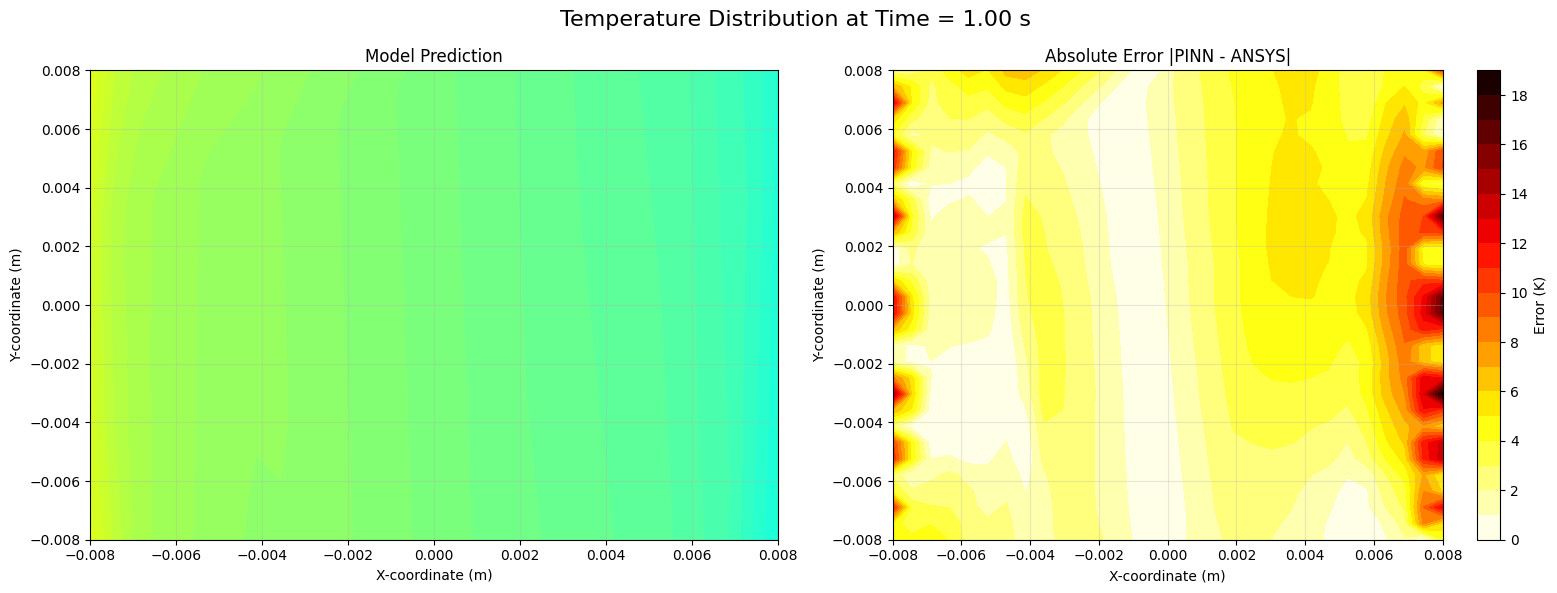

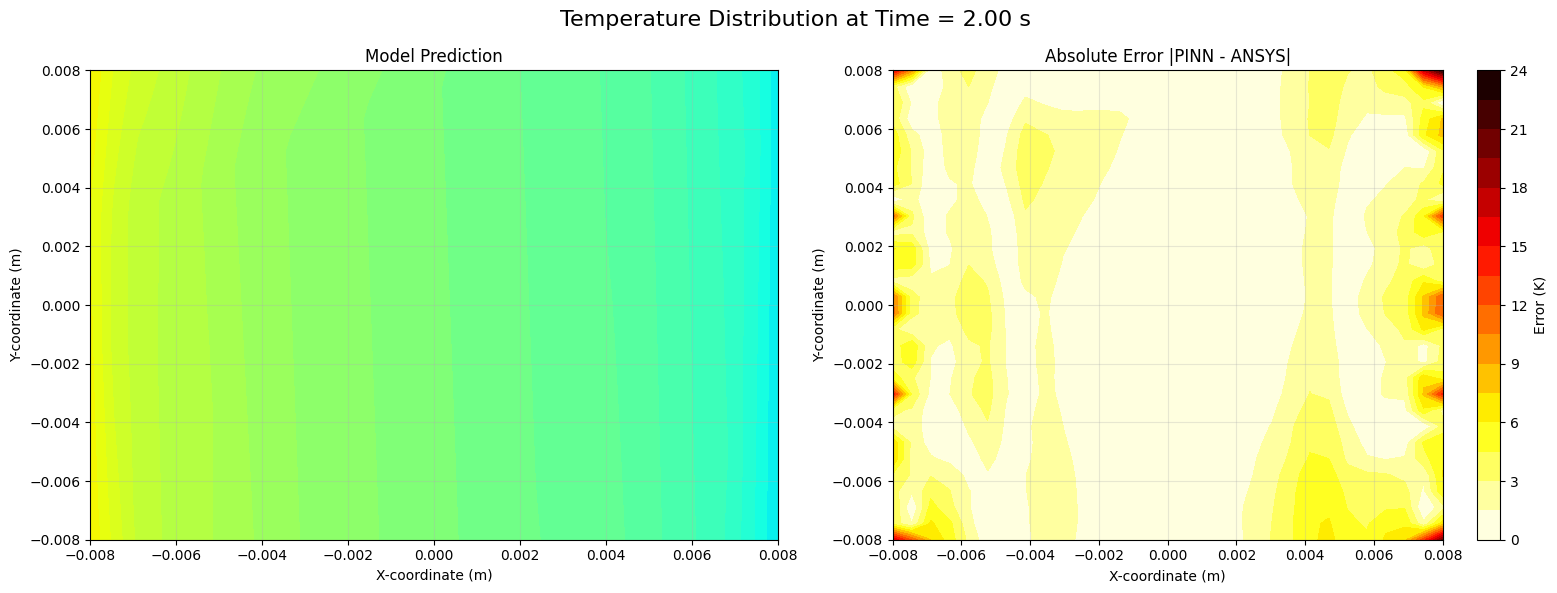

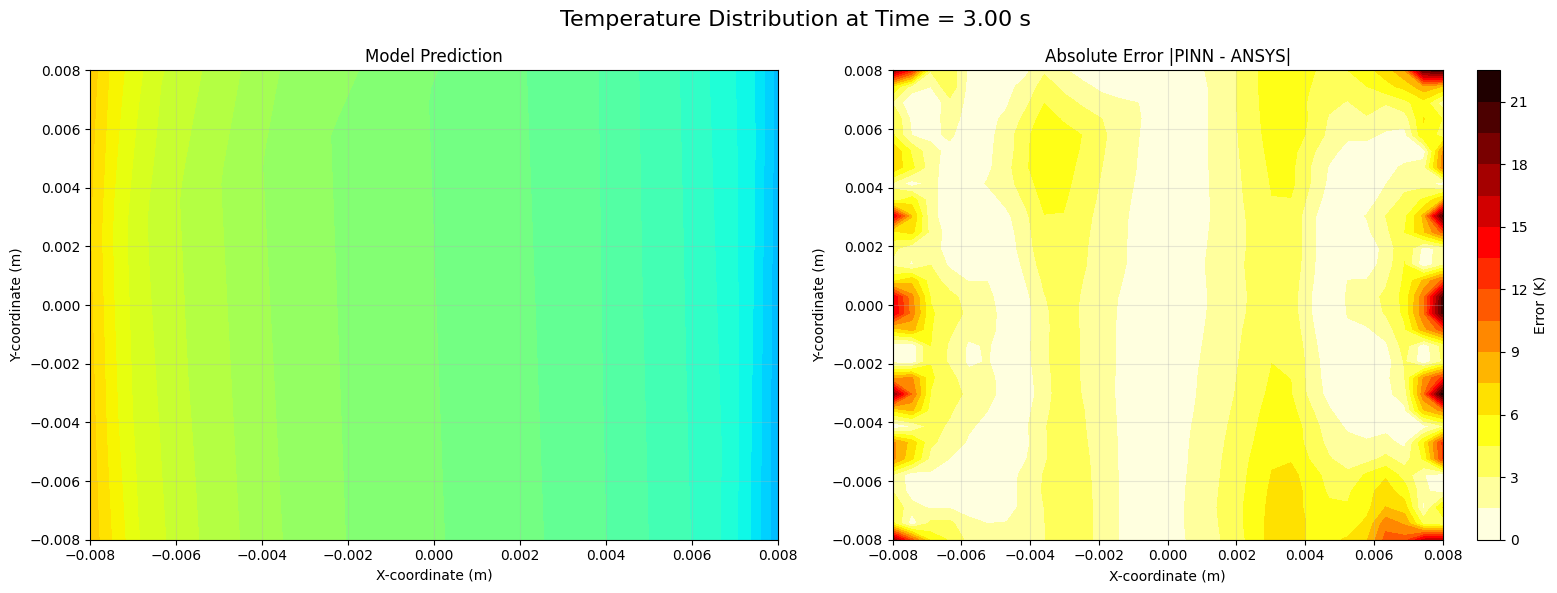

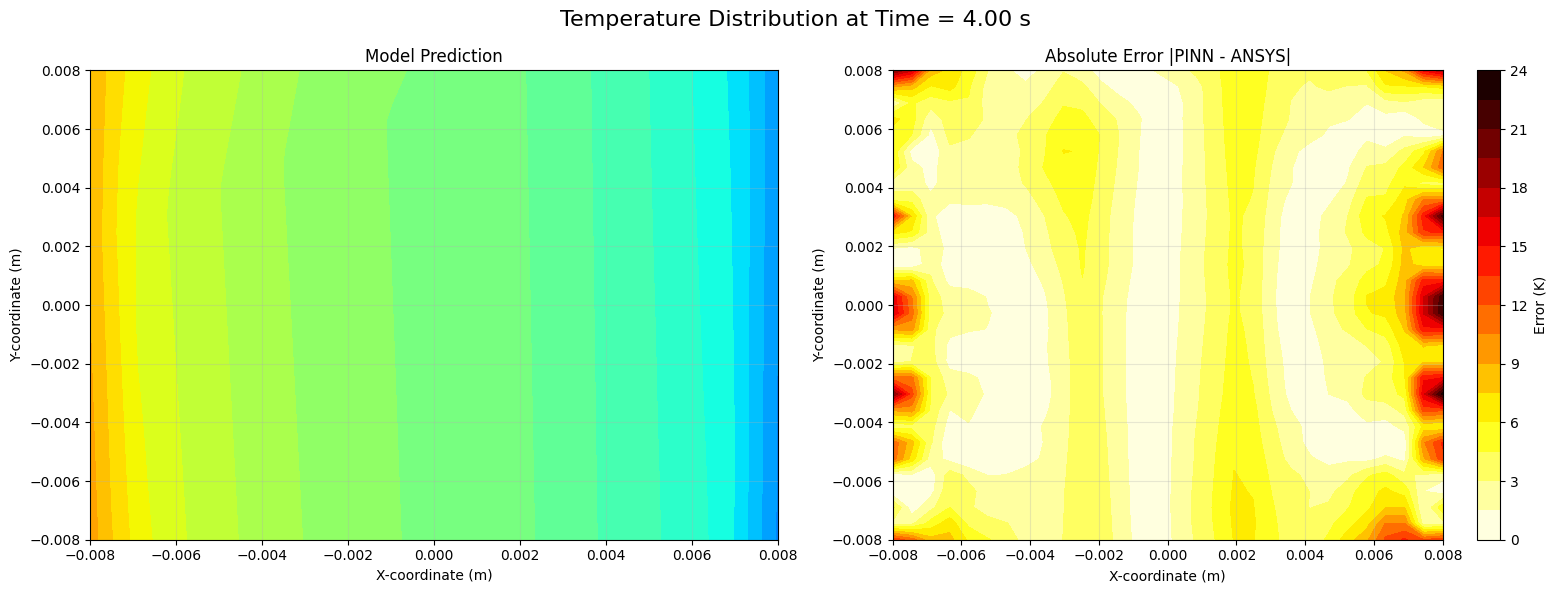

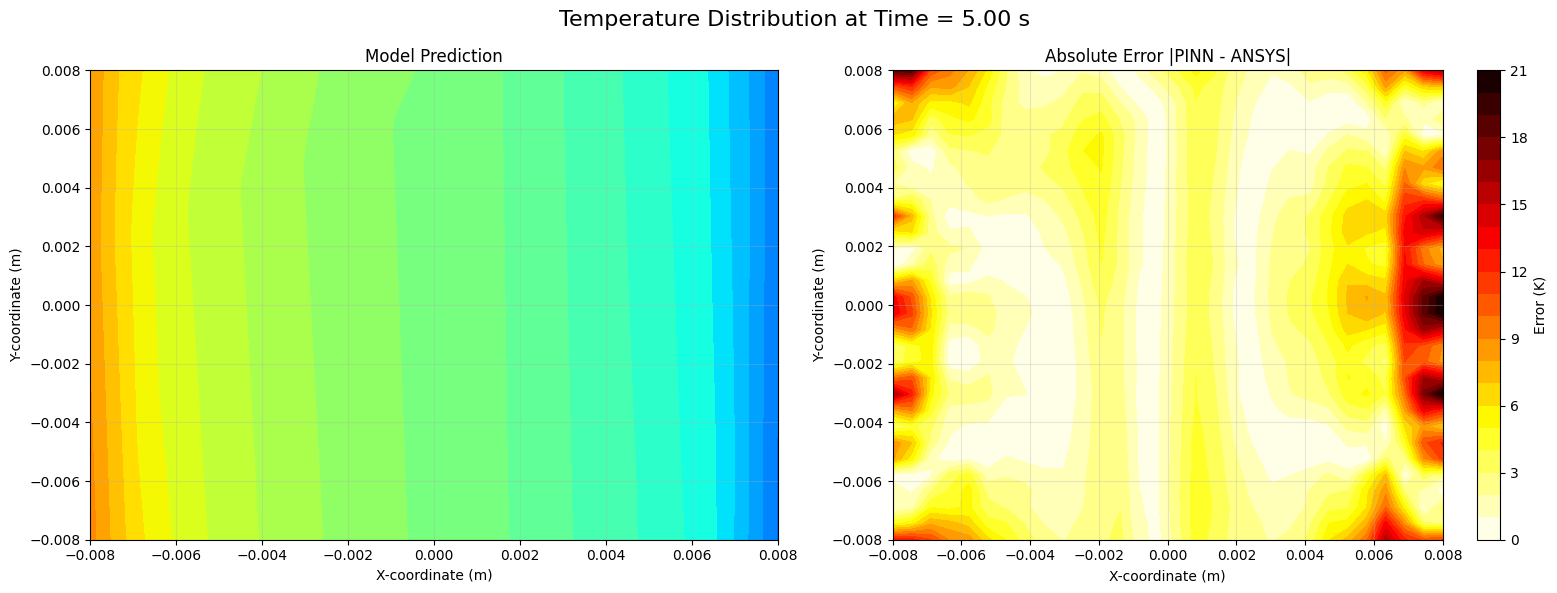

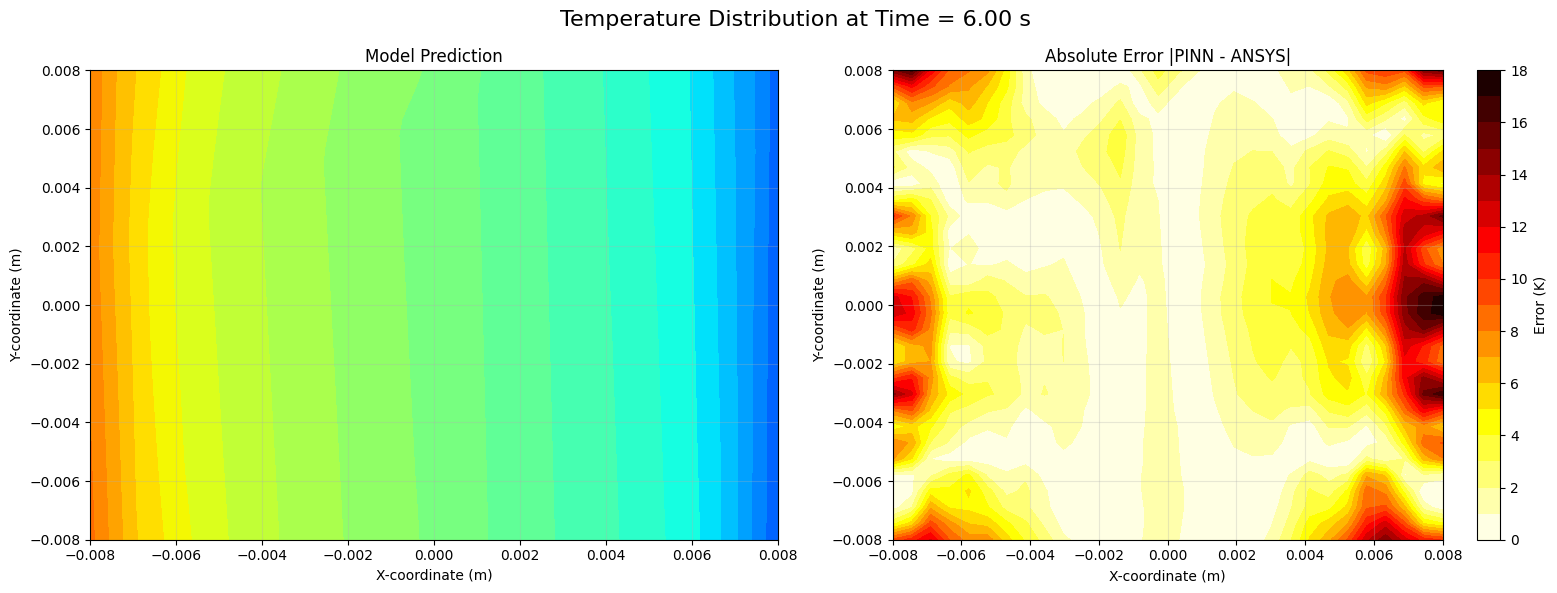

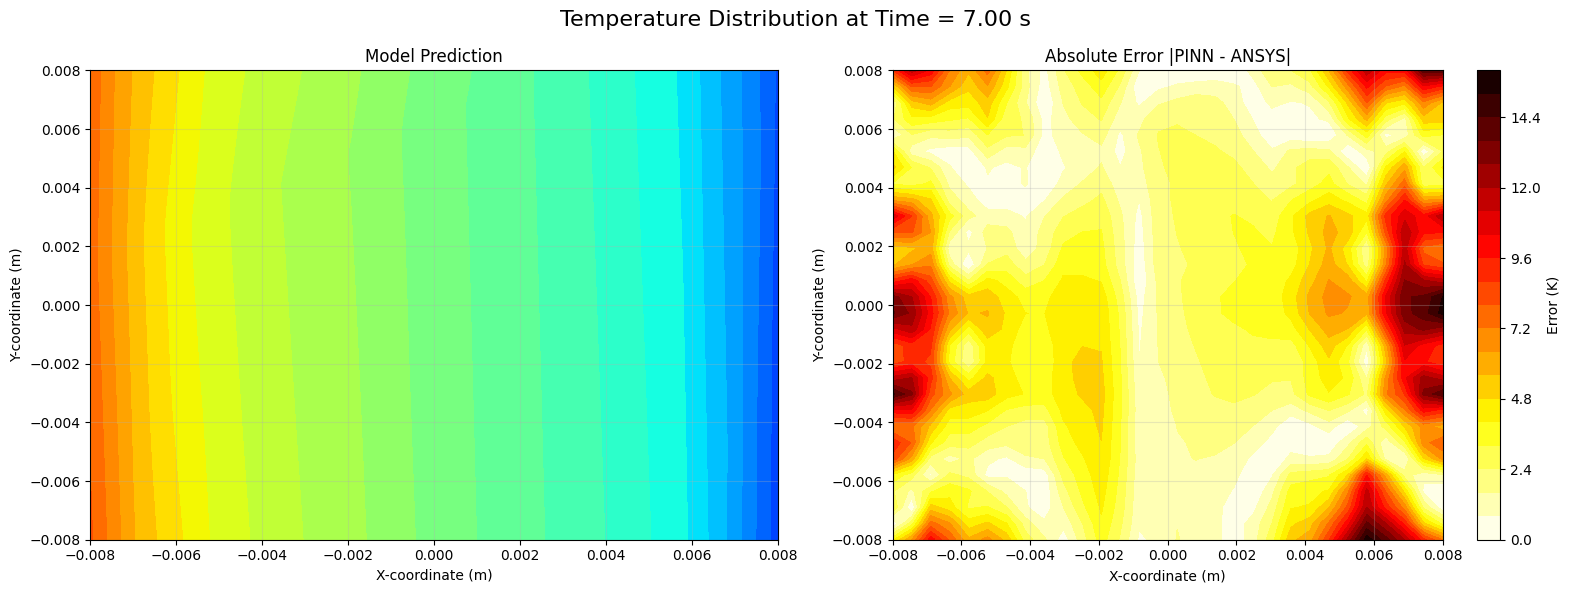

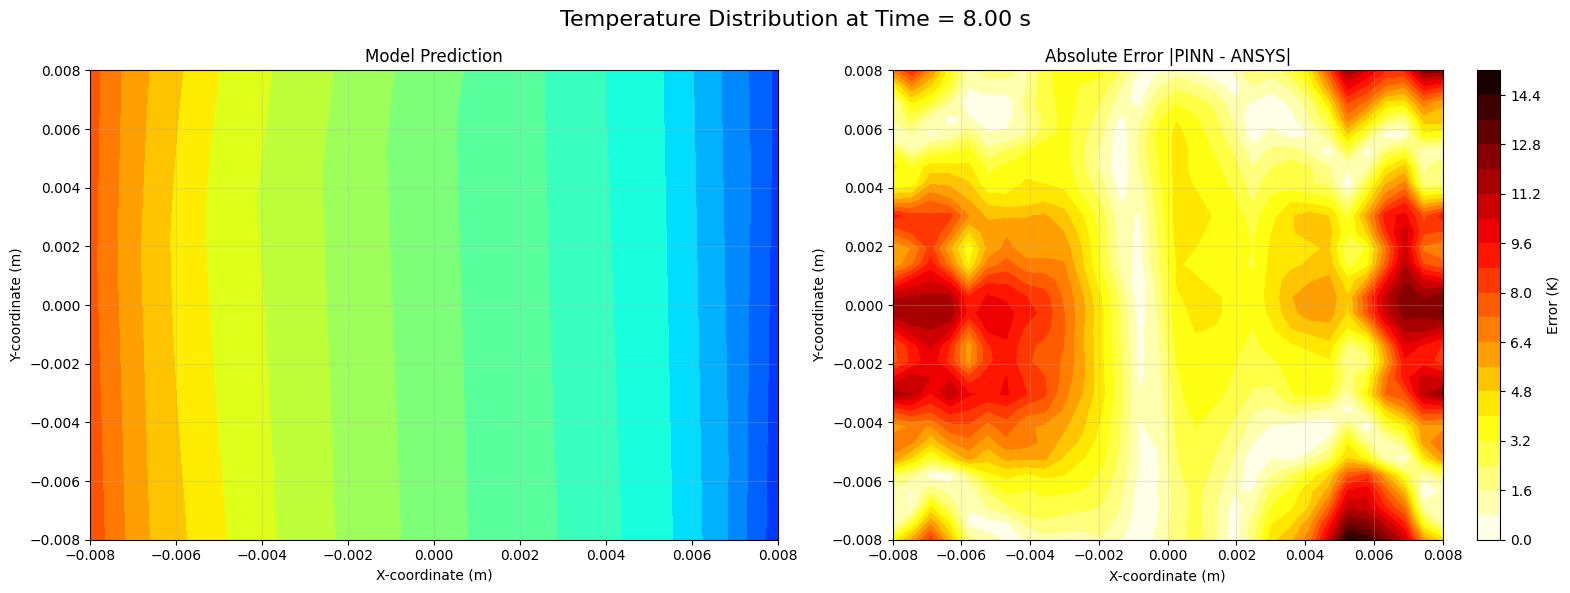

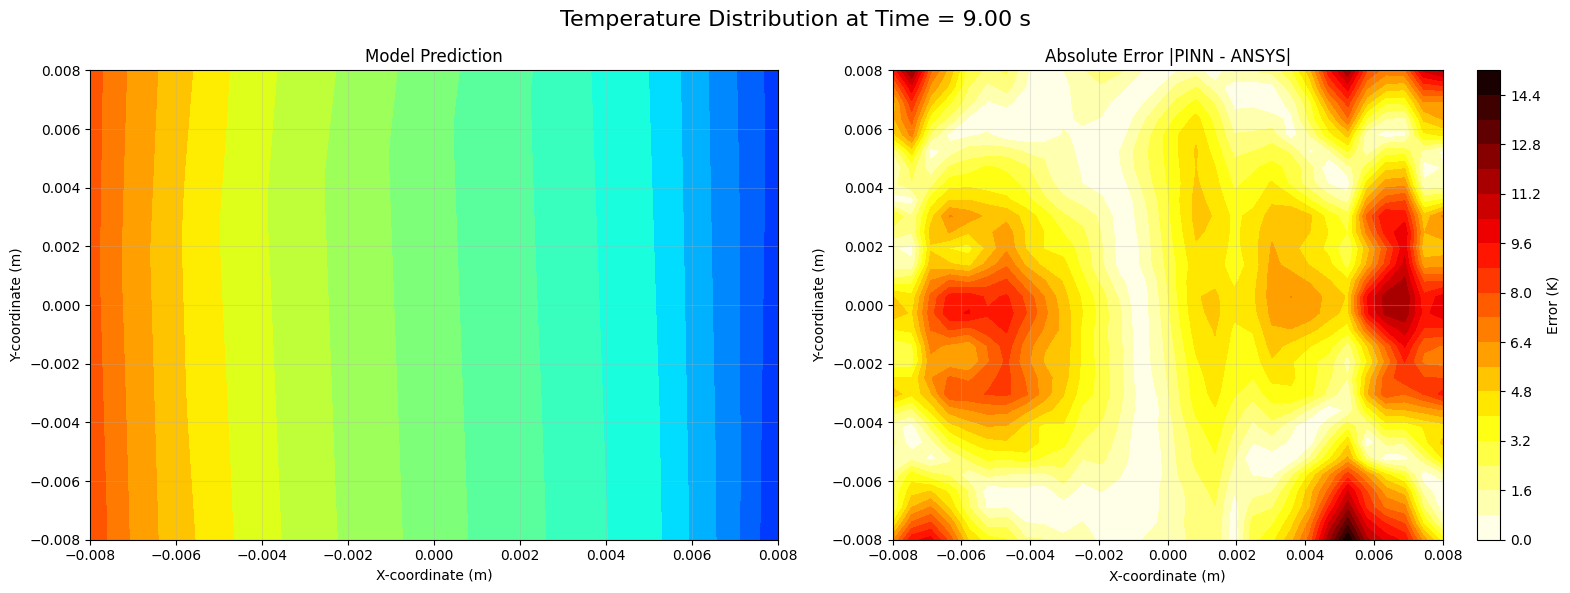

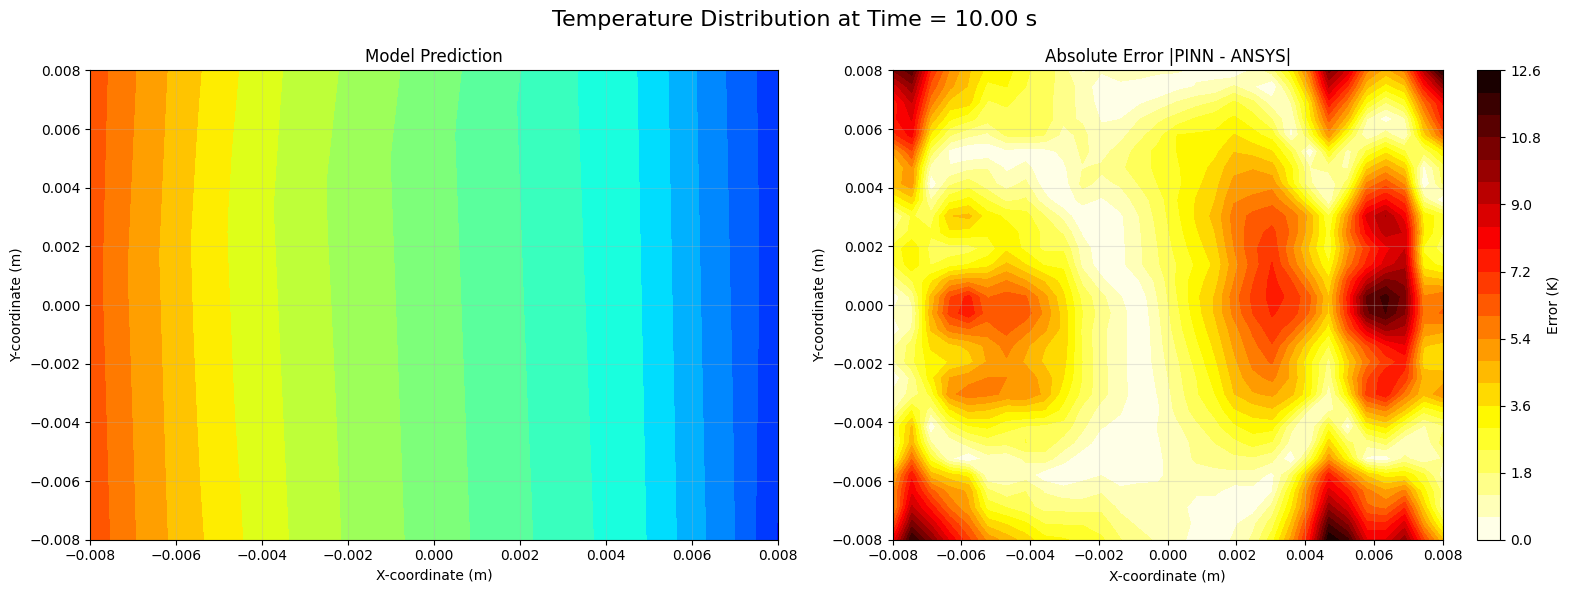

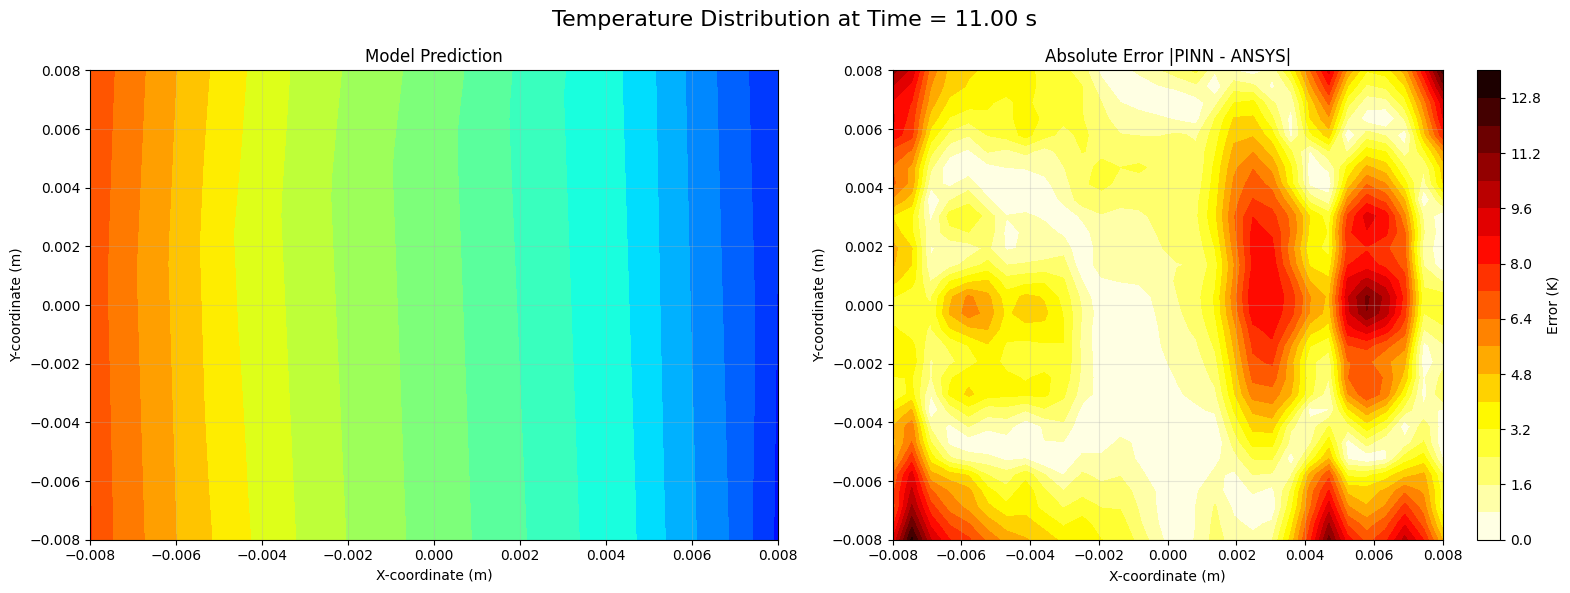

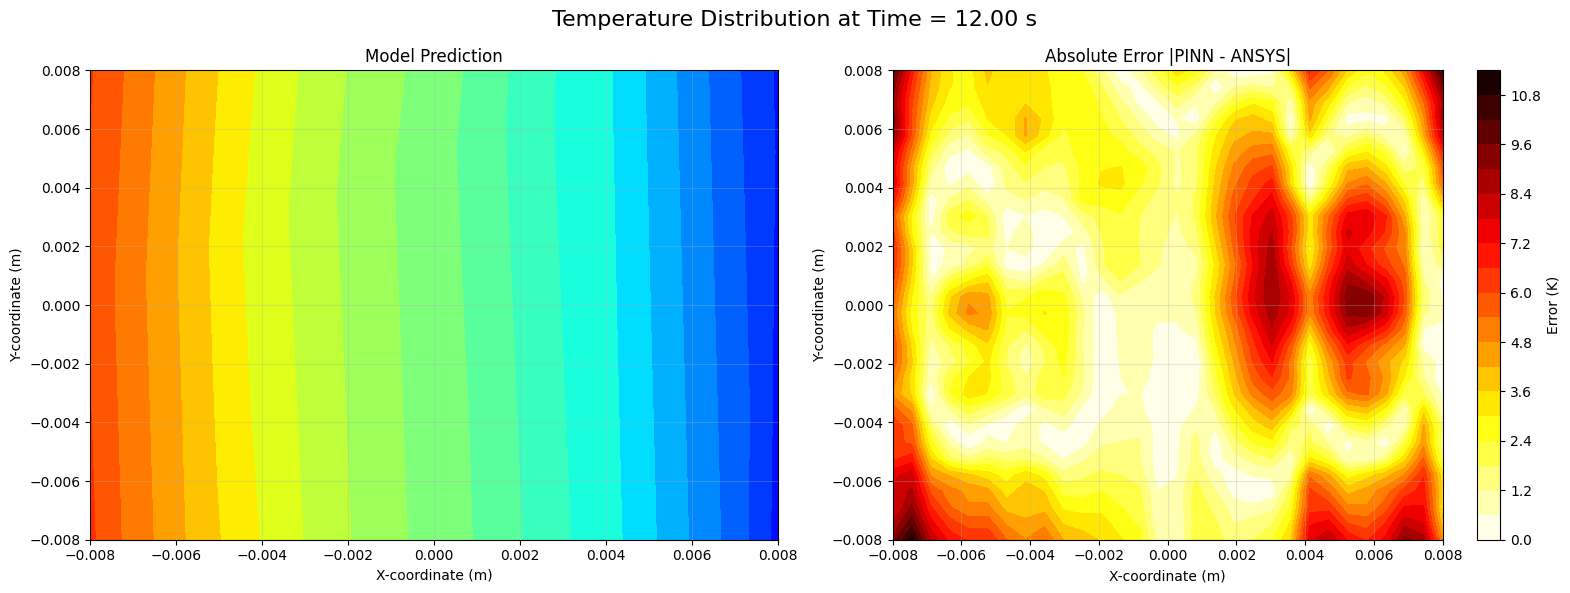

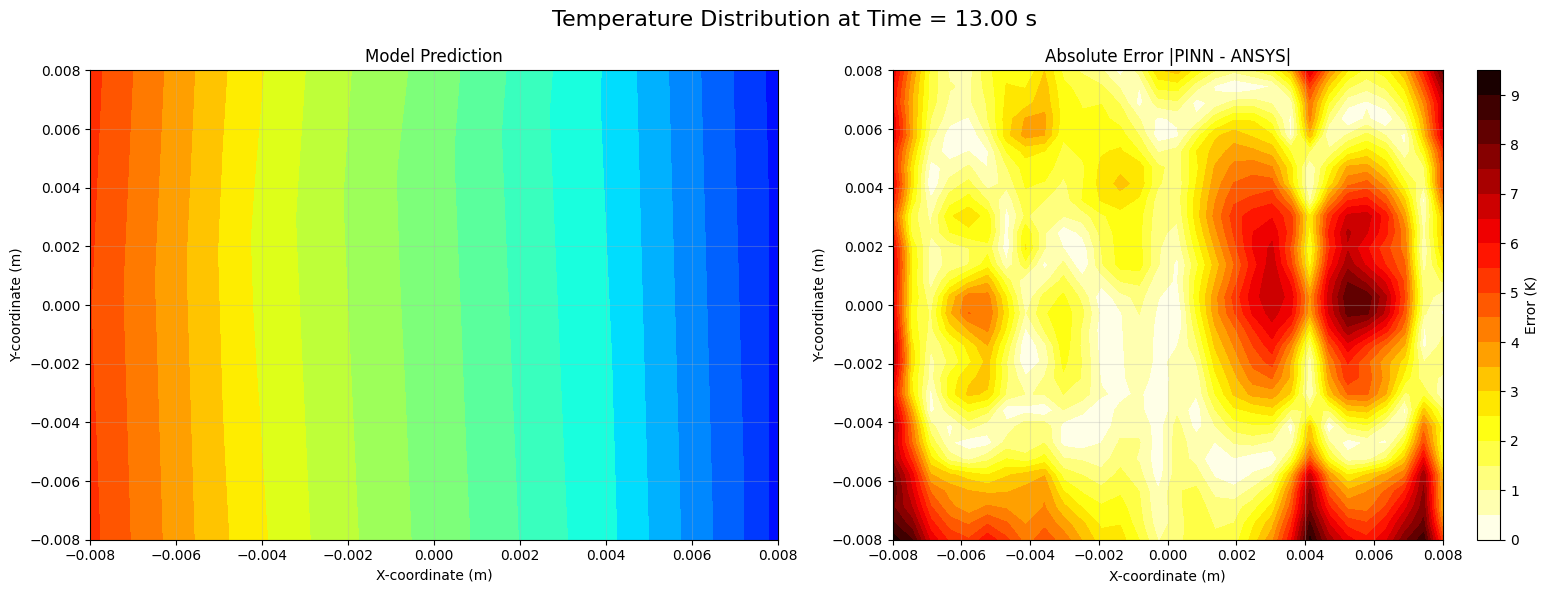

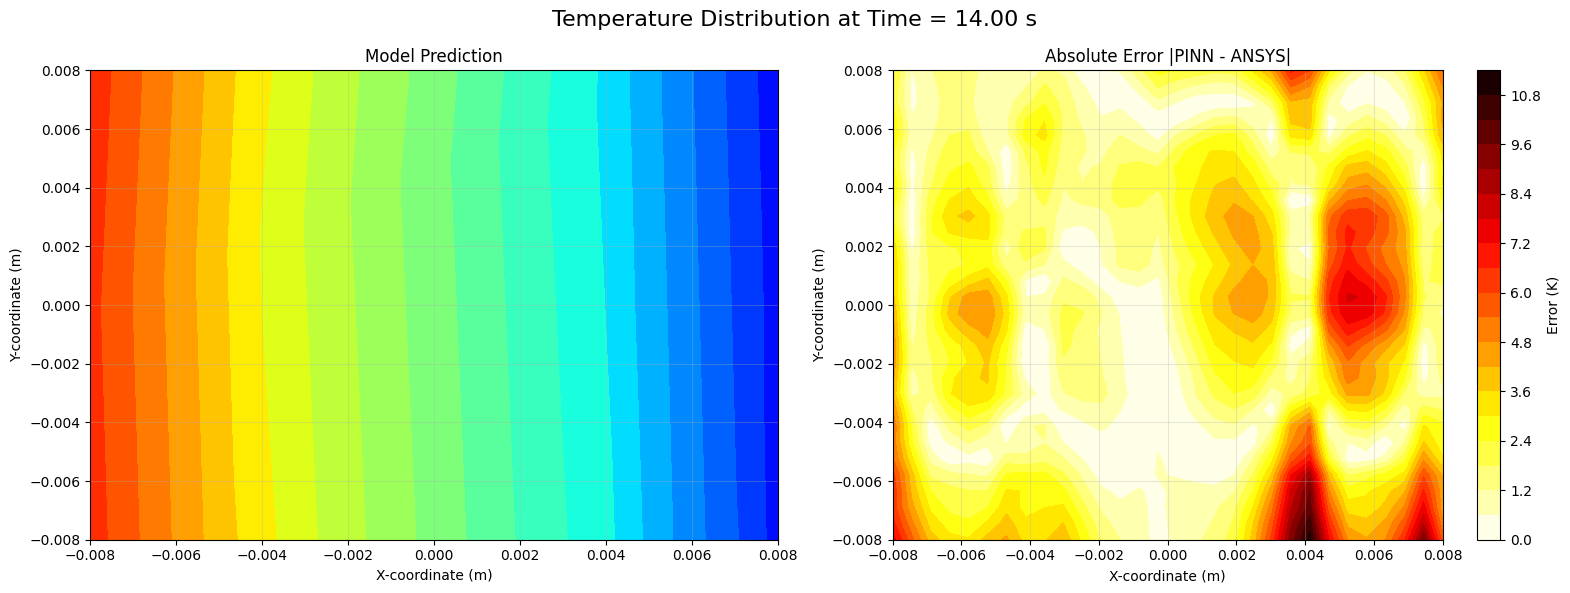

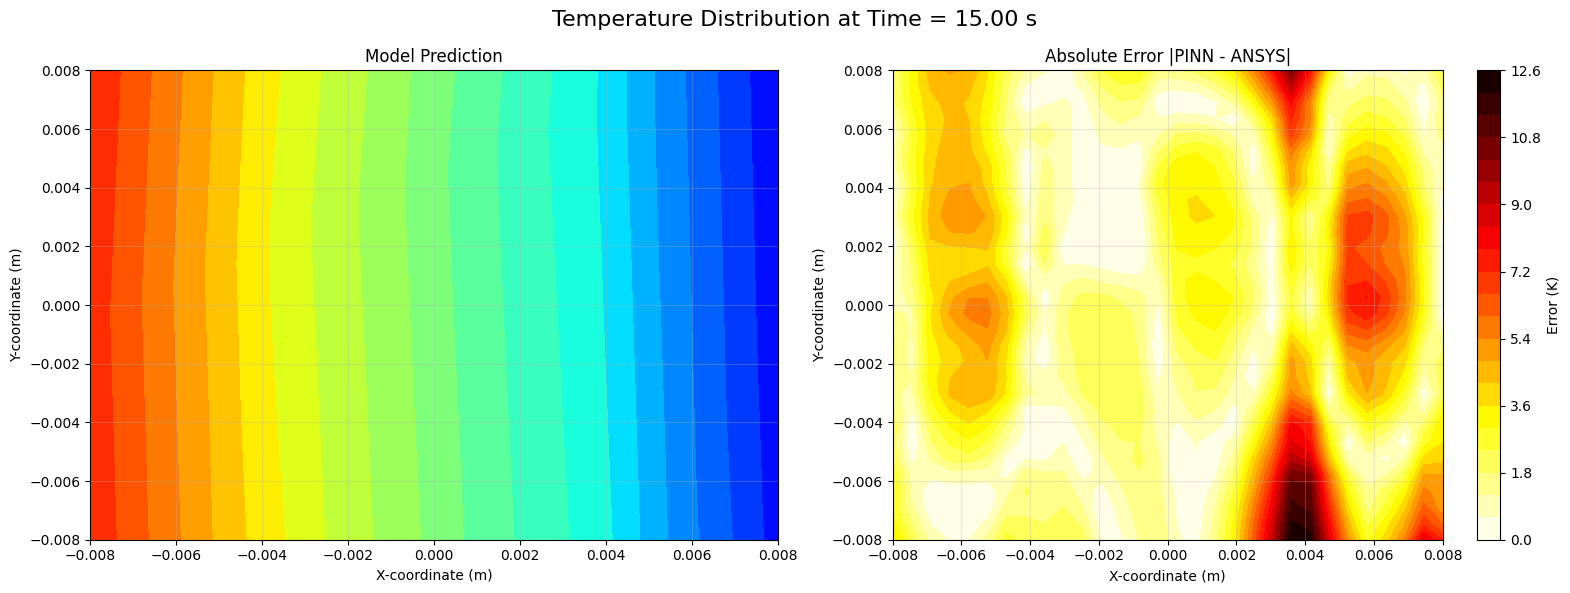

In [ ]:
from scipy.interpolate import griddata

x_min, x_max = -0.008, 0.008
y_min, y_max = -0.008, 0.008

grid_size = 30
x = np.linspace(x_min, x_max, grid_size)
y = np.linspace(y_min, y_max, grid_size)
xx, yy = np.meshgrid(x, y)

time_points = np.sort(df['time'].unique())

for time_point in time_points:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    fig.suptitle(f'Temperature Distribution at Time = {time_point:.2f} s', fontsize=16)

    xx_norm = (xx - df['x-coordinate'].min()) / (df['x-coordinate'].max() - df['x-coordinate'].min())
    yy_norm = (yy - df['y-coordinate'].min()) / (df['y-coordinate'].max() - df['y-coordinate'].min())
    time_norm = (time_point - df['time'].min()) / (df['time'].max() - df['time'].min())

    input_array = np.column_stack([
        xx_norm.flatten(),
        yy_norm.flatten(),
        np.full(xx_norm.size, time_norm)
    ])

    pred_temps = model.predict(input_array, verbose=0).reshape(xx.shape)

    contour1 = ax1.contourf(xx, yy, pred_temps, levels=20, cmap='jet', vmin=0, vmax=500)
    ax1.set_title('Model Prediction')
    ax1.set_xlabel('X-coordinate (m)')
    ax1.set_ylabel('Y-coordinate (m)')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True, alpha=0.3)

    ansys_data = df[np.isclose(df['time'], time_point, atol=1e-3)]
    if not ansys_data.empty:
        grid_ansys = griddata(
            (ansys_data['x-coordinate'], ansys_data['y-coordinate']),
            ansys_data['temperature'],
            (xx, yy),
            method='linear'
        )
        grid_ansys = np.nan_to_num(grid_ansys, nan=np.mean(ansys_data['temperature']))

        abs_error = np.abs(pred_temps - grid_ansys)
        contour2 = ax2.contourf(xx, yy, abs_error, levels=20, cmap='hot_r')
        ax2.set_title('Absolute Error |PINN - ANSYS|')
        cbar2 = fig.colorbar(contour2, ax=ax2)
        cbar2.set_label('Error (K)')
    else:
        ax2.text(0.5, 0.5, 'No ANSYS data available for this time point',
                 ha='center', va='center', fontsize=12)

    ax2.set_xlabel('X-coordinate (m)')
    ax2.set_ylabel('Y-coordinate (m)')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
